<br><br><br>
<br>
<center><h1 style='color:purple'>Sizing of a PV+ST system exploiting the heuristic logic</h1></center>
<br>
<br><br><br><br>

<h2>Homework Definition</h2>

<p>Let us consider an industry that would like to be equipped with a photovoltaic system (PV) and an electrical 
storage (ST). Write and deliver a report in order to take advantage from an economical viewpoint.</p>
<p>The electrical load request as well as the PV power production per kW peak installed in four typical days, 
one per season, are reported in the following tables:</p>

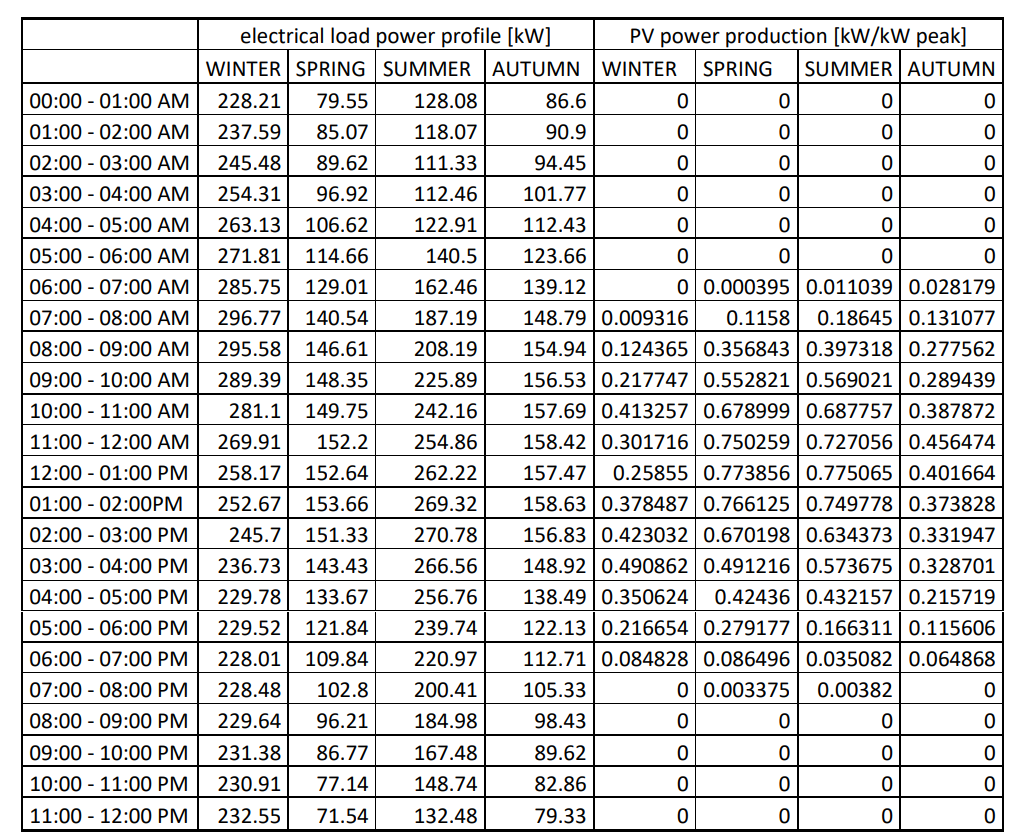

<p>Assuming that</p>
<ul>
    <li>the ST system is characterized by:</li>
        <ul>
            <li>Efficiency during the charging phase: 92%</li>
            <li>Efficiency during the discharging phase: 94%</li>
            <li><p>Each battery pack is a 24kWh module, able to provide at most 6kW both during the charging 
                and discharging phase. This means that the size of the ST unit is multiple of 24kWh as well as 
                the maximum power available is multiple of 6kW, according to the number of installed 
                batteries.</p></li>
            <li>Installation cost: 350€/kWh size</li>
            <li>Medium life span: 10 years</li>
        </ul>
    <li>The PV system:</li>
        <ul>
            <li>Cost: 1500 €/kW peak</li>
            <li>Medium life span: 20 years</li>
        </ul>
    <li>The main grid (external DSO) prices:</li>
        <ul>
            <li>Energy bought</li>
            <ul>
                <li>between 8:00 AM and 8:00 PM is 0.256 €/kWh</li>
                <li>other time slot is 0.198 €/kWh</li>
            </ul>
            <li>Energy sold 0.08 c€/kWh</li>
        </ul>
</ul>
<p>After implementing in Matlab (or other software, if preferred) the “heuristic rule”, use it for determine the 
optimal size of PV and ST in order to maximize benefits during the whole span life (20 years) of the system 
PV+ST. Use the actualization index WACC=1.2% in the definition of the life span plant costs.</p>
<p>Provide also an economical analysis involving the Payback Period, the Net Present Value, the Discount 
Profitability Ratio and the Internal Rate of Return.</p>
<p>Finally show the valued benefit comparing the case 0 (no installation) with the case with PV and ST optimally 
sized.</p>
<br>
<hr>

<h2>Network and Components Representation</h2>

<p>The network depicted in Figure 6.1 consisting of:</p>
<ul>
    <li>a photovoltaic unit (PV)</li>
    <li>a storage device (ST)</li>
<li>an electric load</li>
<li>the connection to an external network.</li>
</ul>

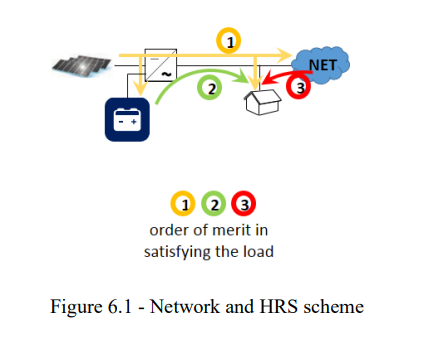

<p>From a mathematical point of view, this network can be described by the single bus-bar (SBB) model, so that the only electric constraint is the active power balance which can be written as follows</p>
<br>
<h2 style='color:red'>$$P_{NET,t}+P_{ST,t}+P_{PV,t}+P_{EL,t}= 0$$</h2>
<br>
<p>where</p>
<ul>
<li>$P_{PV,t}$ the power injected by the PV unit at time t</li>
<li>$P_{ST,t}$ the power injected by the storage device at time t (Negative for charging, Positive for discharging)</li>
<li>$P_{NET,t}$ the power injected by the external network at time t (Positive for Buying from the grid, Negative for selling to the grid)</li>
<li>$P_{EL,t}$ the power injected (hence negative) by the electric load at time t</li>
</ul>
<p>Capacity is the total amount of electricity that a solar battery can store, measured in kilowatt-hours (kWh). Most home solar batteries are designed to be “stackable,” which means that you can include multiple batteries with your solar-plus-storage system to get extra capacity.</p>
<p>power rating is the amount of electricity that a battery can deliver at one time. It is measured in kilowatts (kW).</p>
<br>
<p>The storage system is represented by the injected active power, $P_{ST,t}$(kW), and the storage energy content, $W_{ST,t}$(kWh).</p>
<h2 style='color:red'>$$P_{ST,t}= \left\{\begin{matrix}
\frac{1}{\eta _{ST,in}}\frac{W_{ST,t-1}-W_{ST,t}}{\Delta t} & W_{ST,t-1}< W_{ST,t} & Charging\\ 
\eta _{ST,out}\frac{W_{ST,t-1}-W_{ST,t}}{\Delta t} & W_{ST,t-1} \geqslant  W_{ST,t} & Discharging
\end{matrix}\right.$$</h2>
<br>
<p>Boundries:</p>
<h2 style='color:red'>$$W_{ST,min}\leqslant W_{ST,t} \leqslant W_{ST,max}$$</h2>
<br>
<h2 style='color:red'>$$P_{ST,Charge}\leqslant P_{ST,t} \leqslant P_{ST,Discharge}$$</h2>
<br>
<br>
<p>HRS procedure can be described as:</p>
<ul>
<li>A. if the renewable generation power is greater than demand and the state of charge of the storage is lower than the maximum, then charge the battery, otherwise sell the exceeding energy to the main grid;</li>
<li>B. if the renewable generation power is less than demand and the state of charge of the battery is greater than minimum, then discharge the battery and if it is not sufficient absorb power from the main grid.</li>
</ul>

<hr><h2>Import Data</h2>

In [1]:
import numpy as np
from  openpyxl import *
import numpy_financial as npf
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import pyplot

<hr><h2>Load Data</h2>

In [2]:
raw_data = load_workbook('PVST_heuristic.xlsx')
data=raw_data['Foglio1']

# electrical load (negative) [KW]
p_el = np.array([[m.value for m in t] for t in data['B3':'E26']])

# PV production per KW peak
p_pv = np.array([[m.value for m in t] for t in data['F3':'I26']])

In [3]:
def convertDataToDict(data_lst):
    dic = {0:{},1:{},2:{},3:{}}
    for i in range(4):
        for j in range(len(data_lst)):
            dic[i][j] = data_lst[j][i]
    return(dic)

In [4]:
el_dic = convertDataToDict(p_el)
pv_dic = convertDataToDict(p_pv)

<hr>
<h2>Initial Data</h2>

In [5]:
# PV cost: Euro/KW
PVcost_perKW = 1500

# storage cost: Euro/KWh
STcost_perKWh = 350

# Efficiency during the charging phase
eta_st_in = 0.92

# Efficiency during the discharging phase
eta_st_out = 0.94

dt = 1

# actualization index (2020) 1.2%
WACC = 0.012

<br>
<h2><pre style="color:Tomato;">CaseDefine()</pre></h2>
<br>

<hr>

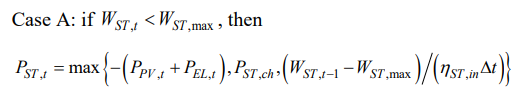

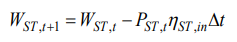

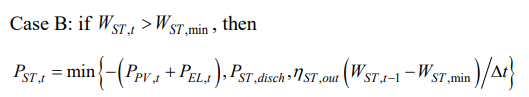

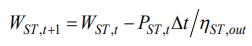

In [6]:
def CaseDefine(p_pv, p_el, w_st, w_st_max):
    w_st_min = 0
    #w_st_min = 0.1 * w_st_max
    # Case A:
    if - (p_pv + p_el) < 0:
        if w_st < w_st_max:
            # Storage Charging
            p_st_1 = (w_st - w_st_max) / (eta_st_in * dt)
            # maximum power allowed in the charging phase for each battery pack is 6 KW:
            p_st_2 = - (w_st_max/4)
            # Excess amount of generated energy
            p_st_3 = - (p_pv + p_el)
            # choosing the MAX value for storage power
            p_st = max(p_st_1, p_st_2, p_st_3)
            w_st = w_st - (p_st * eta_st_in * dt)
        else:
            p_st = 0
            w_st = w_st_max

    # Case B:
    elif - (p_pv + p_el) > 0:
        if w_st > w_st_min:
            # Storage Discharging
            p_st_1 = (w_st - w_st_min) * (eta_st_out / dt)
            # maximum power allowed in the discharging phase for each battery pack is 6 KW:
            p_st_2 = (w_st_max/4)
            # lack of amount of generated energy
            p_st_3 = - (p_pv + p_el)
            # choosing the MIN value for storage power
            p_st = min(p_st_1, p_st_2, p_st_3)
            w_st = w_st - (p_st * (1 / eta_st_out) * dt)
        else:
            p_st = 0
            w_st = w_st_min
    else:
        p_st = 0
        w_st = w_st
        
    return(w_st, p_st)

<hr>
<h2><pre style="color:Tomato;">ElectricityPrice()</pre></h2>
<br>

In [7]:
def ElectricityPrice(j):    
    c_sell = 0.04    # Euro/KWh
    #c_buy = 0.1652
    # price of buying electricity from Energy market based on the daily time slots       
    if 8 <= j < 20:
        c_buy = 0.256   # Euro/KWh
    else:
        c_buy = 0.198   # Euro/KWh
    return(c_buy, c_sell)

<hr>
<h2><pre style="color:Tomato;">CostNetYear()</pre></h2>
<br>

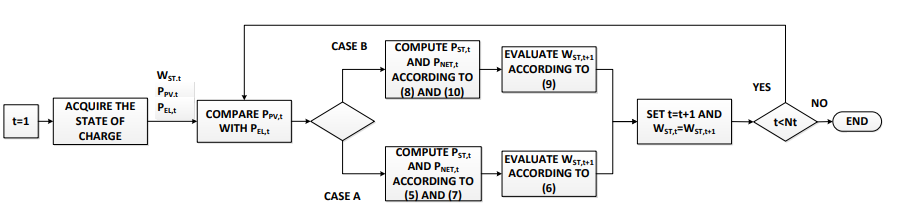

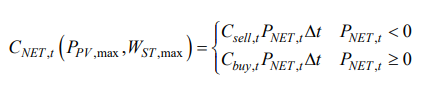

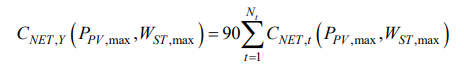

In [8]:
def CostNetYear(pv_max, w_st_max):
    # Each battery pack is a 24 KWh module. This means that the size of the ST unit is multiple of 24 KWh.
    
    w_st = [0]
    p_net_cost = 0

    for i in range(4):
        for j in range(24):

            p_el = el_dic[i][j] * (-1)      # KW
            p_pv = pv_dic[i][j] * pv_max    # KW

            w_st.append(CaseDefine(p_pv, p_el, w_st[-1], w_st_max)[0])
            p_st = CaseDefine(p_pv, p_el, w_st[-1], w_st_max)[1]
            
            c_buy = ElectricityPrice(j)[0]
            c_sell = ElectricityPrice(j)[1]
            
            p_net = - p_st - p_pv - p_el

            if p_net >= 0:
                p_net_cost += (p_net * c_buy * dt)
            elif p_net < 0:
                p_net_cost += (p_net * c_sell * dt)
                
    p_net_cost *= 365/4
    
    return(p_net_cost)

<hr>
<h2><pre style="color:Tomato;">ActualizationFactor()</pre></h2>
<br>

In [9]:
# compute actualization factor
def ActualizationFactor(WACC, years):
    if WACC > 0:
        x = 1 / (1 + WACC)
        actualization_factor = np.sqrt(x) * (1 - x ** years) / (1 - x)
    elif WACC == 0:
        actualization_factor = years
    return(actualization_factor)

<hr>
<h2><pre style="color:Tomato;">CostNetLife()</pre></h2>
<br>

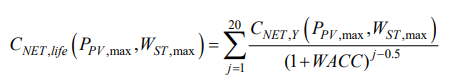

In [10]:
life_span_pv = 20
def CostNetLife(pv_max, w_st_max, life_span):
    c_net_life = CostNetYear(pv_max, w_st_max) * ActualizationFactor(WACC, life_span)
    #c_net_life = 0
    #for y in range(1, life_span + 1):
        #c_net_life += CostNetYear(pv_max, battery_num) / ((1 + WACC) ** (y - 0.5))
    return(c_net_life)

<hr>
<h2><pre style="color:Tomato;">InvestmentCost()</pre></h2>
<br>

In [11]:
def InvestmentCost(pv_max, w_st_max):
    investment_cost = (pv_max * PVcost_perKW) + ((w_st_max * STcost_perKWh) * (1 + (1 / ((1 + WACC) ** 9.5))))
    return(investment_cost)

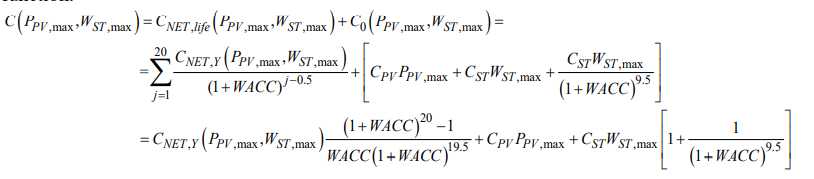

<hr>
<h2><pre style="color:Tomato;">TotalCostGain()</pre></h2>
<br>

In [12]:
def TotalCostGain(pv_max, w_st_max, life_span):
    total_cost_gain = CostNetLife(pv_max, w_st_max, life_span) + InvestmentCost(pv_max, w_st_max)
    return(total_cost_gain)

<hr>
<h2><pre style="color:Tomato;">HRS()</pre></h2>
<br>

In [13]:
def HRS(max_pv, max_w_st_max, life_span):
    hrs = []
    for j in range(0, max_w_st_max+1, 24):
        for i in range(0, max_pv+1, 10):
            hrs.append([i , j , TotalCostGain(i, j, life_span)])
    hrs = sorted(hrs, key = lambda lst : lst[2])
    return(hrs, hrs[0][0], hrs[0][1], hrs[0][2])

In [14]:
hrs_opt = HRS(1200, 1000, 20)
print()
print('Optimal PV size: ', hrs_opt[1], '[m**2]')
print('Optimal ST size: ', hrs_opt[2], '[KWh]')
print('Optimal total cost (20 year): ', hrs_opt[3], '[Euro]')


Optimal PV size:  1080 [m**2]
Optimal ST size:  552 [KWh]
Optimal total cost (20 year):  3415879.3948615333 [Euro]


<hr style="height:2px;border-width:0;color:gray;background-color:gray">
<br><br><br>
<center><h1 style="color:purple">ECONOMIC ANALYSIS</h1></center>
<br>

<br>
<center><h2>Payback Period (PP)</h2></center>
<br>

<p>The payback period is the length of time it takes to recover the cost of an investment or the length of time an investor needs to reach a breakeven point.</p>

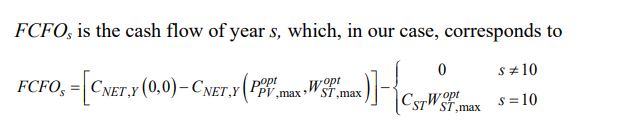

<br>
<br>
<h2><pre style="color:Tomato;">FCFOS()</pre></h2>
<br>

In [15]:
def FCFOS(pv_opt, w_st_opt):
    fcfos = CostNetYear(0, 0) - CostNetYear(pv_opt, w_st_opt)
    return(fcfos)

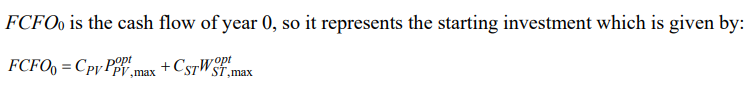

<br>
<br>
<h2><pre style="color:Tomato;">FCFO0()</pre></h2>
<br>

In [16]:
def FCFO0(pv_opt, w_st_opt, year):
    if year >= 10:
        fcfo0 = (pv_opt * PVcost_perKW) + (2 * (w_st_opt * STcost_perKWh))
    else:
        fcfo0 = (pv_opt * PVcost_perKW) + (w_st_opt * STcost_perKWh)
    return(fcfo0)

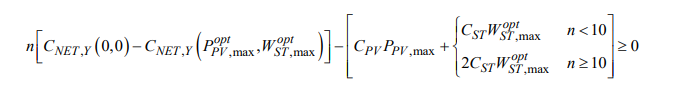

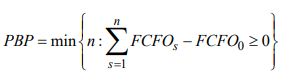

<br>
<br>
<h2><pre style="color:Tomato;">PaybackPeriod()</pre></h2>
<br>

In [17]:
def PaybackPeriod(pv_opt, w_st_opt, year):
    for y in range(1,year+1):
        pp = (y * FCFOS(pv_opt, w_st_opt)) - FCFO0(pv_opt, w_st_opt,y)
        if pp >=0:
            return(y)
            break

<br>
<center><h2>Net Present Value(NPV)</h2></center>
<br>

<p>Net present value (NPV) is the difference between the present value of cash inflows and the present value of cash outflows over a period of time.</p>
<p>The NPV measures the excess or shortfall of cash flows, in present value terms, above the cost of funds. It is defined as the algebraic sum of the FCFOs over all the years of the analysis horizon discounted at an interest rate (WACC). In the case study the NPV is:</p>

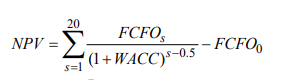

<br>
<br>
<h2><pre style="color:Tomato;">NPV()</pre></h2>
<br>

In [18]:
def NPV(pv_opt, w_st_opt, year):
    npv = (FCFOS(pv_opt, w_st_opt) * ActualizationFactor(WACC, year)) - FCFO0(pv_opt, w_st_opt, year)
    return(npv)

<br>
<center><h2>Discounted Profitability Ratio</h2></center>
<br>


The DPR provides the percentage return of the investment expenditure along the lifetime of the project. It is 
the ratio between the Net Present Value and the Initial Investment.

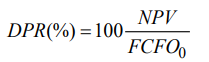

<br>
<br>
<h2><pre style="color:Tomato;">DPR()</pre></h2>
<br>

In [19]:
def DPR(pv_opt, w_st_opt, year):
    dpr = NPV(pv_opt, w_st_opt, year) / FCFO0(pv_opt, w_st_opt, year) * 100
    return(dpr)

<br>
<center><h2>Internal Rate of Return</h2></center>
<br>

<p>The IRR is the rate of return that makes the NPV equal to zero. It can also be defined as the discount rate at which the present value of all future cash flow is equal to the initial investment or in other words the rate at which an investment breaks even.</p>
<p>IRR calculations are commonly used to evaluate the desirability of investments or projects. The higher a project's IRR is, the more desirable it is to undertake the project.</p>

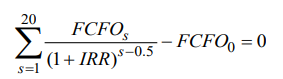

<br>
<br>
<h2><pre style="color:Tomato;">IPR()</pre></h2>
<br>

In [20]:
def IRR(pv_opt, w_st_opt, year):
    lst = [-FCFO0(pv_opt, w_st_opt, year)]
    for y in range(1,year+1):
        lst.append(FCFOS(pv_opt, w_st_opt))
    irr = npf.irr(lst) * 100
    return(irr)

<hr style="height:2px;border-width:0;color:gray;background-color:gray">
<br><br><br>
<center><h1 style="color:purple">RESULTS</h1></center>
<br><br><br>

In [21]:
def Result(pv_opt, w_st_opt, year):
    # economic analysis
    irr = IRR(pv_opt, w_st_opt, year)
    dpr = DPR(pv_opt, w_st_opt, year)
    npv = NPV(pv_opt, w_st_opt, year)
    pp = PaybackPeriod(pv_opt, w_st_opt, year)
    tcg = TotalCostGain(pv_opt, w_st_opt, year)
    tic = InvestmentCost(pv_opt, w_st_opt)
    
    # showing the results inside the pretty table
    x = PrettyTable()
    x.field_names = ["Outputs", "Values", "Units"]
    x.add_rows([
        ["Optimal PV Size", pv_opt, 'KW'],
        ["Optimal ST Size", w_st_opt, 'KWh'],
        ["Optimal Total Gain (for 20 years)", round(tcg,2), 'Euro'],
        ["Total Investment Cost", round(tic,2), 'Euro'],
        ["Internal Rate of Return (IRR)", round(irr,3), '%'],
        ["Discounted Profitability Ratio (DPR)", round(dpr,3), '%'],
        ["Net Present Value (NPV)", round(npv,2), 'Euro'],
        ["Payback Period (PP)", pp, 'Years'],
    ])
    x.align = "l"
    x.align["Units"] = "c"
    print(x)

In [22]:
Result(1080,552,20)

+--------------------------------------+------------+-------+
| Outputs                              | Values     | Units |
+--------------------------------------+------------+-------+
| Optimal PV Size                      | 1080       |   KW  |
| Optimal ST Size                      | 552        |  KWh  |
| Optimal Total Gain (for 20 years)    | 3415879.39 |  Euro |
| Total Investment Cost                | 1985701.25 |  Euro |
| Internal Rate of Return (IRR)        | 11.923     |   %   |
| Discounted Profitability Ratio (DPR) | 137.056    |   %   |
| Net Present Value (NPV)              | 2749892.19 |  Euro |
| Payback Period (PP)                  | 7          | Years |
+--------------------------------------+------------+-------+


<hr style="height:2px;border-width:0;color:gray;background-color:gray">
<br><br><br>
<center><h1 style="color:purple">PLOT THE RESULT</h1></center>
<br><br><br>

In [23]:
def CasePlot(pv_max, w_st_max):
    # Each battery pack is a 24kWh module. This means that the size of the ST unit is multiple of 24kWh.
    
    w_st = [0]
    p_el_ls = list()
    p_pv_ls = list()
    p_net_buy = list()
    p_net_sell = list()
    p_st_ch = list()
    p_st_dsch = list()

    for i in range(4):
        for j in range(24):

            p_el = el_dic[i][j] * (-1)      # KW
            p_pv = pv_dic[i][j] * pv_max    # KW

            w_st.append(CaseDefine(p_pv, p_el, w_st[-1], w_st_max)[0])
            p_st = CaseDefine(p_pv, p_el, w_st[-1], w_st_max)[1]
            
            p_net = - p_st - p_pv - p_el
                
            p_el_ls.append(p_el)
            p_pv_ls.append(p_pv)
            
            if p_net >= 0:
                p_net_buy.append(p_net)
                p_net_sell.append(0)

            if p_net < 0:
                p_net_buy.append(0)
                p_net_sell.append(p_net)
            
            if p_st >= 0:
                p_st_ch.append(0)
                p_st_dsch.append(p_st)
            if p_st < 0:
                p_st_ch.append(p_st)
                p_st_dsch.append(0)         
    
    return(p_el_ls, p_pv_ls, p_net_buy, p_net_sell, p_st_ch, p_st_dsch, w_st)

In [24]:
opt_plot = CasePlot(1080, 552)

In [25]:
%matplotlib inline

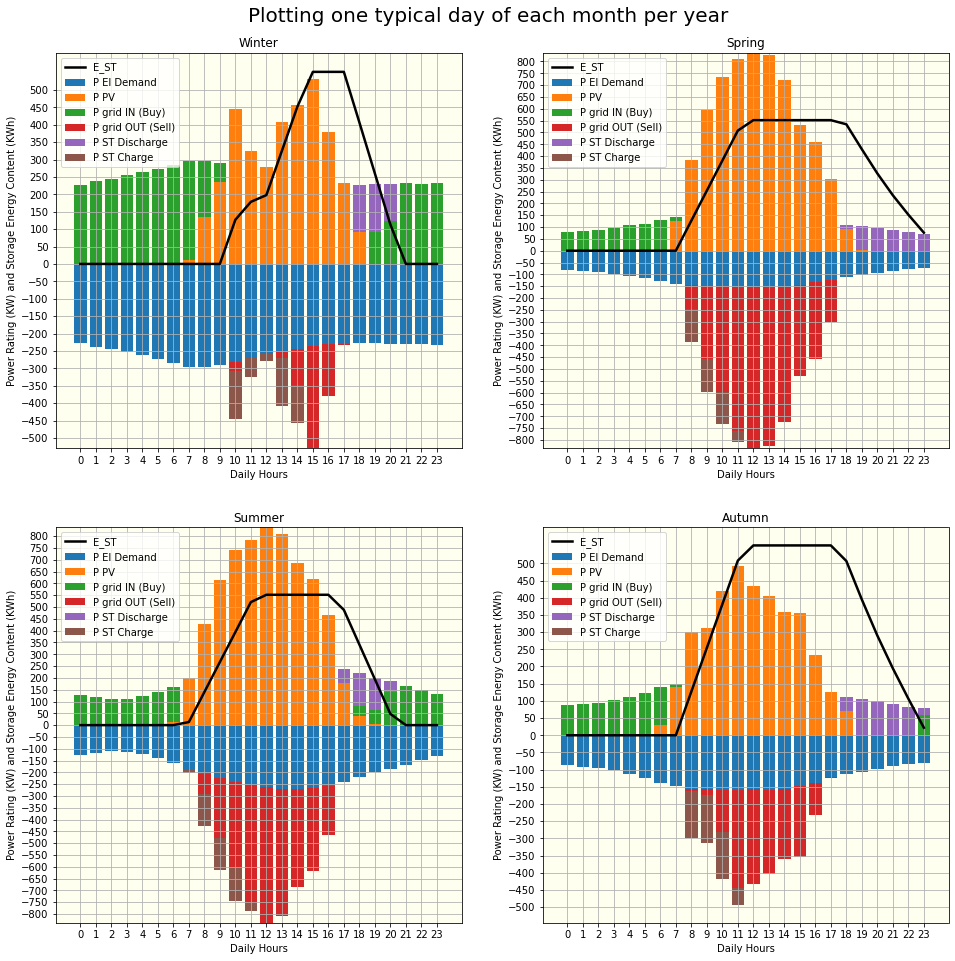

In [31]:
time_wi = range(24)
time_sp = range(24,48)
time_su = range(48,72)
time_au = range(72,96)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (16,16))
plt.suptitle('Plotting one typical day of each month per year', fontsize=20, y=0.92)

ax1.bar(time_wi, [i for i in opt_plot[0][:24]], label='P El Demand')
ax1.bar(time_wi, [i for i in opt_plot[1][:24]], label='P PV')
ax1.bar(time_wi, [i for i in opt_plot[2][:24]], bottom = [opt_plot[1][t] for t in time_wi], label='P grid IN (Buy)')
ax1.bar(time_wi, [i for i in opt_plot[3][:24]], bottom = [opt_plot[0][t] for t in time_wi], label='P grid OUT (Sell)')
ax1.bar(time_wi, [i for i in opt_plot[5][:24]], bottom = [opt_plot[1][t] + opt_plot[2][t] for t in time_wi], 
        label = 'P ST Discharge')
ax1.bar(time_wi, [i for i in opt_plot[4][:24]], bottom = [opt_plot[0][t] + opt_plot[3][t] for t in time_wi], 
        label = 'P ST Charge')
ax1.plot(time_wi, [i for i in opt_plot[6][1:25]], 'k', label='E_ST', linewidth=2.5)
ax1.set_xlabel('Daily Hours')
ax1.set_ylabel('Power Rating (KW) and Storage Energy Content (KWh)')
ax1.set_xticks(range(24))
ax1.set_yticks(range(-500,501,50))
ax1.set_facecolor("ivory")
ax1.set_title('Winter')
ax1.grid(True)
ax1.legend()


ax2.bar(time_sp, [i for i in opt_plot[0][24:48]], label='P El Demand')
ax2.bar(time_sp, [i for i in opt_plot[1][24:48]], label='P PV')
ax2.bar(time_sp, [i for i in opt_plot[2][24:48]], bottom = [opt_plot[1][t] for t in time_sp], label='P grid IN (Buy)')
ax2.bar(time_sp, [i for i in opt_plot[3][24:48]], bottom = [opt_plot[0][t] for t in time_sp], label='P grid OUT (Sell)')
ax2.bar(time_sp, [i for i in opt_plot[5][24:48]], bottom = [opt_plot[1][t] + opt_plot[2][t] for t in time_sp], 
        label='P ST Discharge')
ax2.bar(time_sp, [i for i in opt_plot[4][24:48]], bottom = [opt_plot[0][t] + opt_plot[3][t] for t in time_sp], 
        label='P ST Charge')
ax2.plot(time_sp, [i for i in opt_plot[6][25:49]], 'k', label='E_ST', linewidth=2.5)
ax2.set_xlabel('Daily Hours')
ax2.set_ylabel('Power Rating (KW) and Storage Energy Content (KWh)')
ax2.set_xticks(range(24,48))
ax2.set_xticklabels(range(24))
ax2.set_yticks(range(-800,801,50))
ax2.set_facecolor("ivory")
ax2.set_title('Spring')
ax2.grid(True)
ax2.legend()

ax3.bar(time_su, [i for i in opt_plot[0][48:72]], label='P El Demand')
ax3.bar(time_su, [i for i in opt_plot[1][48:72]], label='P PV')
ax3.bar(time_su, [i for i in opt_plot[2][48:72]], bottom = [opt_plot[1][t] for t in time_su], label='P grid IN (Buy)')
ax3.bar(time_su, [i for i in opt_plot[3][48:72]], bottom = [opt_plot[0][t] for t in time_su], label='P grid OUT (Sell)')
ax3.bar(time_su, [i for i in opt_plot[5][48:72]], bottom = [opt_plot[1][t] + opt_plot[2][t] for t in time_su], 
        label='P ST Discharge')
ax3.bar(time_su, [i for i in opt_plot[4][48:72]], bottom = [opt_plot[0][t] + opt_plot[3][t] for t in time_su], 
        label='P ST Charge')
ax3.plot(time_su, [i for i in opt_plot[6][49:73]], 'k', label='E_ST', linewidth=2.5)
ax3.set_xlabel('Daily Hours')
ax3.set_ylabel('Power Rating (KW) and Storage Energy Content (KWh)')
ax3.set_xticks(range(48,72))
ax3.set_xticklabels(range(24))
ax3.set_yticks(range(-800,801,50))
ax3.set_facecolor("ivory")
ax3.set_title('Summer')
ax3.grid(True)
ax3.legend()

ax4.bar(time_au, [i for i in opt_plot[0][72:96]], label='P El Demand')
ax4.bar(time_au, [i for i in opt_plot[1][72:96]], label='P PV')
ax4.bar(time_au, [i for i in opt_plot[2][72:96]], bottom = [opt_plot[1][t] for t in time_au], label='P grid IN (Buy)')
ax4.bar(time_au, [i for i in opt_plot[3][72:96]], bottom = [opt_plot[0][t] for t in time_au], label='P grid OUT (Sell)')
ax4.bar(time_au, [i for i in opt_plot[5][72:96]], bottom = [opt_plot[1][t] + opt_plot[2][t] for t in time_au], 
        label='P ST Discharge')
ax4.bar(time_au, [i for i in opt_plot[4][72:96]], bottom = [opt_plot[0][t] + opt_plot[3][t] for t in time_au], 
        label='P ST Charge')
ax4.plot(time_au, [i for i in opt_plot[6][73:97]], 'k', label='E_ST', linewidth=2.5)
ax4.set_xlabel('Daily Hours')
ax4.set_ylabel('Power Rating (KW) and Storage Energy Content (KWh)')
ax4.set_xticks(range(72,96))
ax4.set_xticklabels(range(24))
ax4.set_yticks(range(-500,501,50))
ax4.set_facecolor("ivory")
ax4.set_title('Autumn')
ax4.grid(True)
ax4.legend()

plt.show()